In [25]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("meteostat_kn.csv")
df.columns = ['date', 'hour', 'temp', 'dew_point', 'humidity', 'precipitation', 'snow', 'wind_direction', 'wind_speed', 'wind_gust', 'pressure', 'sunshine_minutes', 'code']

# Remove rows where the date is newer than the current date
current_date = datetime.now().date()
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' column is in datetime format
df = df[df['date'] < datetime(current_date.year, current_date.month, current_date.day)]
df.tail()

,date,hour,temp,dew_point,humidity,precipitation,snow,wind_direction,wind_speed,wind_gust,pressure,sunshine_minutes,code
591605,2025-05-04,19,10.4,9.5,94.0,1.3,0.0,60.0,4.0,12.0,1009.3,0.0,7.0
591606,2025-05-04,20,10.3,9.2,93.0,1.0,0.0,50.0,5.0,9.0,1009.6,0.0,7.0
591607,2025-05-04,21,10.3,7.9,85.0,0.6,0.0,30.0,9.0,17.0,1009.1,0.0,7.0
591608,2025-05-04,22,9.9,8.3,90.0,1.1,0.0,40.0,6.0,19.0,1009.0,0.0,8.0
591609,2025-05-04,23,9.2,8.1,93.0,0.7,0.0,50.0,10.0,17.0,1008.6,0.0,8.0


In [26]:
df['temp_dew_point_diff'] = df['temp'] - df['dew_point']
df.tail()

,date,hour,temp,dew_point,humidity,precipitation,snow,wind_direction,wind_speed,wind_gust,pressure,sunshine_minutes,code,temp_dew_point_diff
591605,2025-05-04,19,10.4,9.5,94.0,1.3,0.0,60.0,4.0,12.0,1009.3,0.0,7.0,0.9
591606,2025-05-04,20,10.3,9.2,93.0,1.0,0.0,50.0,5.0,9.0,1009.6,0.0,7.0,1.1
591607,2025-05-04,21,10.3,7.9,85.0,0.6,0.0,30.0,9.0,17.0,1009.1,0.0,7.0,2.4
591608,2025-05-04,22,9.9,8.3,90.0,1.1,0.0,40.0,6.0,19.0,1009.0,0.0,8.0,1.6
591609,2025-05-04,23,9.2,8.1,93.0,0.7,0.0,50.0,10.0,17.0,1008.6,0.0,8.0,1.1


In [27]:
features = ['hour', 'temp', 'dew_point', 'temp_dew_point_diff', 'humidity', 'pressure', 'wind_speed', 'wind_gust']
X = df[features]
y = df['code']

In [28]:
# Combine X and y into a single DataFrame for easier handling of NaN values
data = pd.concat([X, y], axis=1)

# Drop rows where any feature or the target is NaN
data = data.dropna()

# Separate X and y again
X = data[features]

# Create binary target: 1 if code is 5 (fog) or 6 (freezing fog), else 0
y = data['code'].apply(lambda x: 1 if x == 5 or x == 6 else 0)

In [29]:
print(X.shape)
print(y.shape)

(63613, 8)
(63613,)


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [31]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid
param_grid = {
    'max_depth': [7, 10, 15],
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3, 0.5]
}

# Recalculate imbalance ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    scale_pos_weight=ratio,
    eval_metric='logloss',
    random_state=42
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5],
                         'max_depth': [7, 10, 15],
                         'n_estimators': [50, 100, 200, 500, 1000]},
             scoring='f1', verbose=1)

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Best parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200}
Best F1 score: 0.7363762240407354


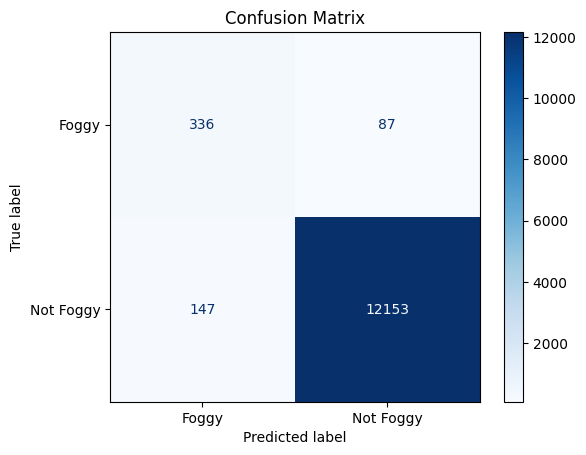

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # 1=foggy, 0=not foggy
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Foggy", "Not Foggy"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


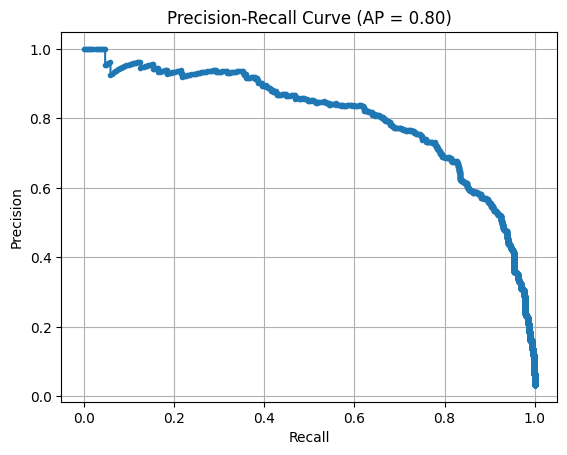

In [34]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_scores = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (foggy)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {ap:.2f})')
plt.grid()
plt.show()


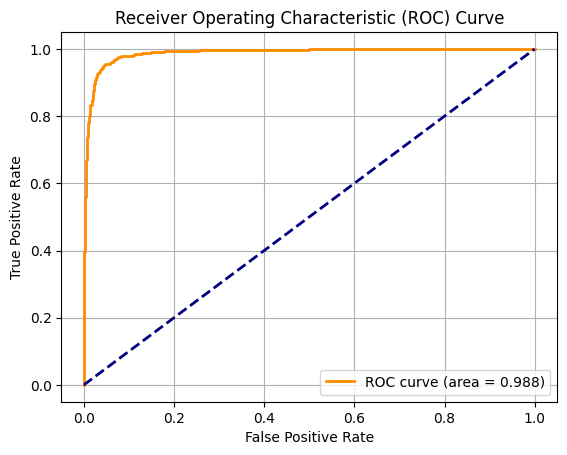

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()